# Exploratory Data Analysis - D207 Project

## I.  Situation and Dictionary Description

### 1.  Provide one question that is relevant to your chosen data set. You will answer this question later in the task through an analysis of the cleaned data, using one of the following techniques: chi-square, t-test, or analysis of variance (ANOVA).

Are there variables that can help us determine when a patient is more likely to be readmitted?  We will investigate a couple of data points and compare between the populations of patients with and without readmission.

### 2.  Explain how stakeholders in the organization could benefit from an analysis of the data.

This could lead to us giving more thought to cases that seem to be heading towards readmission, and pre-emptively combat the problem.  Since the hospital is fined based on excessive readmissions, this could lead to a saving in costs.  Also, it is better for the patients health if we provide more focused care when needed.

### 3.  Identify all of the data in your data set that are relevant to answering your question in part A1.

First, I am going to look at the data point we want to correlate with (Readmission), and then some of the key data points I might use during my investigation.  I will list a large set of possibilities, and then pick out a few that I think are my probable during my analysis.

| Variable | Data Type | Range Type |
|:-------- |:---------:|:----------:|
|Readmission (Primary)|Qualitative|Discrete|
|Age|Quantitative|Continuous|
|Gender|Qualitative|Discrete|
|Overweight|Qualitative|Discrete|
|Services|Qualitative|Discrete|
|Doc Visits|Quantitative|Discrete|
|Vitamin D Levels|Quantitative|Continuous|
|Initial Days|Quantitative|Continuous|
|High Blood Pressure|Qualitative|Discrete|
|Income|Quantitative|Continuous|
|Complication Risk|Qualitative|Discrete|
|Area|Qualitative|Discrete|


## II.  Describe the Data Analysis

### 1.  Using one of the following techniques, write code (in either Python or R) to run the analysis of the data set:

Below are our options for analysis techniques.

| Technique | Use Case |
|:----------|:---------|
|Pearson's R|relationship between two continuous variables|
|Chi-Square|relationship between two categorical (Discrete Qualitative) variables|
|t-Tests|difference on a continuous variable between two groups (categorical)|
|ANOVA|generalized t-Test used to test difference in a continuous variable between 3 or more groups (categorical)|

Since we are starting with a categorical variable (Readmission), we will employee **Chi-Square** and a **t-Test** to investigate relationships and possible correlation.  We will use Rate of readmission because the population sizes differ between the Services.
<br><br>
We will begin with a Chi-Square test using Readmission and the Services performed.<br>We want to determine with 95% certainty that the Services performed are not related to Readmission.
<br><br>
Null Hypothesis: All services have an equal chance of Readmission
<br>
Alternative  Hypthesis: Not all services have an equal chance of Readmission
<br><br>
Significance Level (alpha) = 5%

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import chisquare
from scipy import stats
import seaborn as sns

# Load in the dataset
df = pd.read_csv("medical_clean.csv")

In [2]:
# Get the count of Yes/No for the Readmis column, so we know the overall rate of Readmission
df.ReAdmis.value_counts()

No     6331
Yes    3669
Name: ReAdmis, dtype: int64

In [3]:
# Create a Readmis column of 0 and 1 so we can easily sum it
conditions = [(df['ReAdmis'] == 'Yes'),
    (df['ReAdmis'] != 'No')]
# Create a list of the values
values = [1, 0]

# Add the summable column
df['ReAdmisBit'] = np.select(conditions, values)

# Sum the readmission count by service provided
dfServices_ReAdmis = df.groupby('Services')['ReAdmisBit'].sum()
# Get the count of records for each Service type
dfServices_Totals = df.Services.value_counts()

# Blend the totals together and calculate the percentage of the population that was readmitted
dfServices = pd.concat([dfServices_ReAdmis, dfServices_Totals], axis = 1, join = 'inner')
dfServices['Rate'] = dfServices['ReAdmisBit'] / dfServices['Services']
dfServices

,ReAdmisBit,Services,Rate
Blood Work,1930,5265,0.366572
CT Scan,488,1225,0.398367
Intravenous,1103,3130,0.352396
MRI,148,380,0.389474


In [4]:
# Get the category count, positive count, negative count, and normal percent of population that is readmitted
category_count = len(df.Services.unique())
positive_count = dfServices['ReAdmisBit'].sum()
negative_count = len(df) - positive_count
normal_rate = positive_count / (positive_count + negative_count)

# Create a list of the norm repeating for use in our chi-square function
norms = [normal_rate] * category_count

# find Chi-Square critical value for 95% certainty
crit_value = scipy.stats.chi2.ppf(1 - .05, df = category_count - 1)
# find our current Chi-Square value
chi_square = chisquare(dfServices['Rate'], norms)

print(f'Chi-Square critical value for 3 dof and 5% probability:  {crit_value:.3f}')
print(f'P-value for chi-squared on rate of Readmission/Service: {chi_square[0]:.3f}')

Chi-Square critical value for 3 dof and 5% probability:  7.815
P-value for chi-squared on rate of Readmission/Service: 0.005


Since our Chi-Square p-value (0.005) is well below the critical value (7.815), we fail to reject the Null Hypothesis and determine that there is not sufficient evidence to prove a difference in readmission rate based on Services being provided.

---

Next, we will use a t-Test to see if we can determine if there is a difference between Readmission and Non-Readmission Vitamin D Levels.  Perhaps we can use Vitamin D levels as a warning sign for Readmissions.
<br><br>
Null Hypothesis: The Vitamin D Levels in Readmissions == The Vitamin D Levels in Non-Readmissions
<br>
Alternative  Hypothesis: The Vitamin D Levels in Readmissions <> The Vitamin D Levels in Non-Readmissions
<br><br>
Significance Level (alpha) = 5%

In [5]:
res = stats.ttest_ind(df[df.ReAdmisBit == 1].VitD_levels,
                          df[df.ReAdmisBit == 0].VitD_levels)
print(f'P-value for double sided t-test: {res.pvalue:.4f}')

P-value for double sided t-test: 0.6831


Since our p-Value (0.6831) is greater than our significance (alpha = 0.05), we will fail to reject the Null Hypothesis.  We do not have sufficient evidence to concur that the mean Vitamin D Levels between Readmissions and Non-Readmissions is different.

### 2.  Provide the output and the results of any calculations from the analysis you performed.

For the comparison of Readmission populations by Service type, we received a Chi Square P-value of 0.005.  Using our 3 degrees of freedom (4 services) and 5% probability, we received a critical value of 7.815.  Since our p-value fell below the critical value, we fail to reject the null hypthesis and determine there is not evidence of a difference in the the rate of readmission based on service performed.
<br><br>
For the comparison of Vitamin D leves by Readmission, we received a p value of 0.6831.  Since that was well above our significance level, we fail to reject the Null Hypothesis and concur that the Vitamin D levels are equally distributed among both Readmissions and Non-Readmissions.

### 3.  Justify why you chose this analysis technique.

I chose Chi-Square and t-Test because I wanted to look for relationships between Readmissions (categorical) and multiple other values including both qualitative and quantitative.  Chi-Square allowed us to compare other categorical values to the Readmissions, while a t-Test allowed us to compare using a continuous value.

## III. Additional Distribution Information - Univariate

We will now display some of the distributions with visualizations.  I have chosen Age and Vitamin D Levels for continuos variables, and Area and Service as the categorical variables.

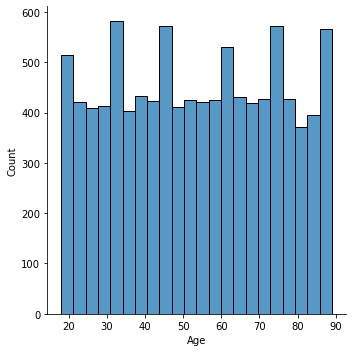

In [6]:
sns.displot(x = df.Age)

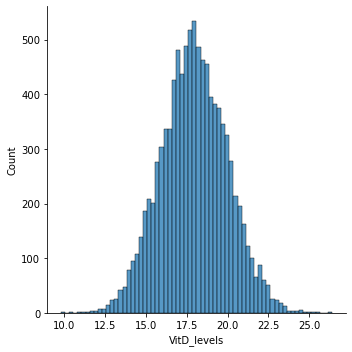

In [7]:
sns.displot(x = df.VitD_levels)

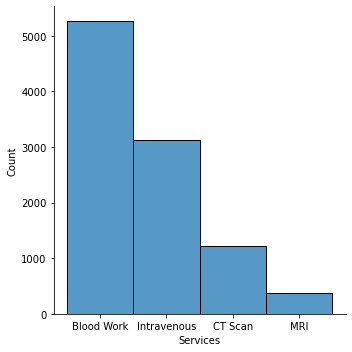

In [8]:
sns.displot(x = df.Services)

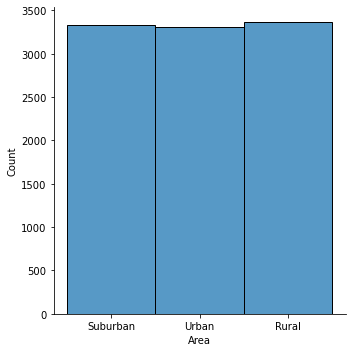

In [9]:
sns.displot(x = df.Area)

## IV. Additional Distribution Information - Bivariate

For bivariate statistics, I compared the following variables -

1. Vitamin D Levels vs High Blood Pressure

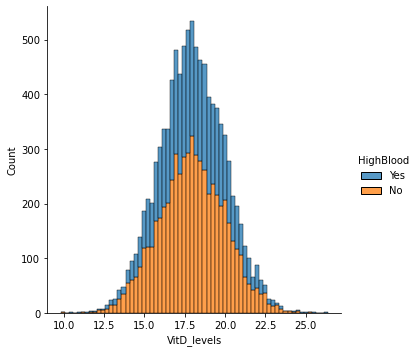

In [10]:
sns.displot(x = df.VitD_levels, hue = df.HighBlood, multiple = "stack")

2. Age vs Additional Charges (this was very interesting as there seemed to be two distinct groupings of charges for each age)

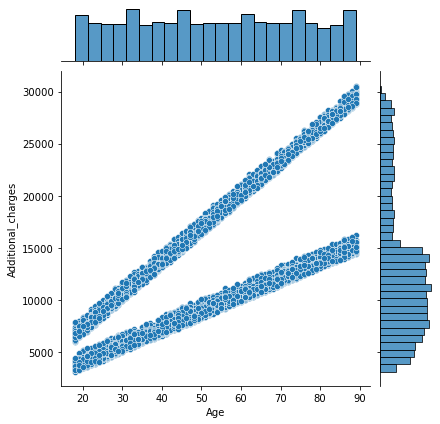

In [11]:
sns.jointplot(x = df.Age, y = df.Additional_charges)

3. Complication Risks vs Overweight

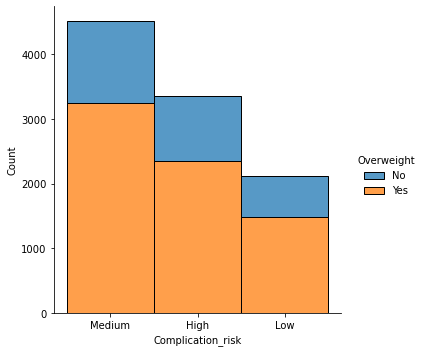

In [12]:
sns.displot(x = df.Complication_risk, hue = df.Overweight, multiple = "stack")

4. Area vs High Blood Pressure

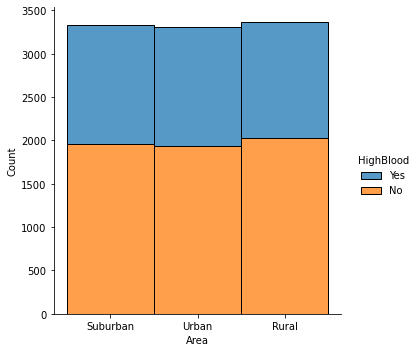

In [13]:
sns.displot(x = df.Area, hue = df.HighBlood, multiple = "stack")

## V.  Summarize Implications of Analysis

### 1.  Discuss the results of the hypothesis test.

Unfortunately, neither of my tests indicated a strong relationship.  That is often the answer.  In the future I would probably start with something like PairGrid from Seaborn and get an initial overview of all relationships - then decide if there is an interesting relationship to explore further.
<br><br>
---
**Recap of Results for Chi-Square Test:**
<br>
Null Hypothesis: All services have an equal chance of Readmission
<br>
Alternative  Hypthesis: Not all services have an equal chance of Readmission
<br>
Significance Level (alpha) = 5%
<br><br>
Chi-Square critical value for 3 dof and 5% probability:  7.815
<br>
P-value for chi-squared on rate of Readmission / service: 0.005
<br><br>
Since our Chi-Square p-value (0.005) is well below the critical value (7.815), we fail to reject the Null Hypothesis and determine that there is not sufficient evidence to prove a difference in readmission rate based on Services being provided.
<br>
---
**Recap of Results for t-Test:**
<br>
Null Hypothesis: The Vitamin D Levels in Readmissions == The Vitamin D Levels in Non-Readmissions
<br>
Alternative  Hypothesis: The Vitamin D Levels in Readmissions <> The Vitamin D Levels in Non-Readmissions
<br>
Significance Level (alpha) = 5%
<br><br>P-value for double sided t-test: 0.6831
<br><br>
For the comparison of Vitamin D leves by Readmission, we received a P-value of 0.6831.  Since that was well above our significance level, we fail to reject the Null Hypothesis and concur that the Vitamin D levels are equally distributed among both Readmissions and Non-Readmissions.
<br>
---


### 2.  Discuss the limitations of your data analysis.

If we found a relationship that we believed to exhibit correlation, it would be prudent to apply linear regression or another method to develop a predictive model.  It would have been beneficial to have even more data points (preferably continuous), to see if we could detect some driving factors.  Running more tests would also be necessary - not just a few t-Tests or Chi-Square hypotheses.

Beyond the initial findings, there are limitations to each analysis type.
<br>
* Chi-Square
 * All participants measured must be independent, meaning that an individual cannot fit in more than one category (When Chi-square Is Appropriate, n.d.)
 * Chi-square tests do not give much information about the strength of the relationship (When Chi-square Is Appropriate, n.d.)
 * Samples need to be truly selected at random for the tests to be accurate (Davila, 2016)
<br><br>
- t-Test
 - Data must be continuous for the t-test to succeed (Maverick, 2019)
 - Samples need to be truly selected at random for the tests to be accurate (Davila, 2016)
 - The data points sampled need to follow a normal distribution (Maverick, 2019)
 - t-Test assume homogeneity of variance (Maverick, 2019)

### 3.  Recommend a course of action based on your results.

I would recommend further data collection on a broader set of attributes, followed by more analysis.  Unfortunately, there were no strong indicators in the values I tested, and this is a common the outcome.  This can commonly be caused by not capturing or testing enough data points that are driving the results.
<br><br>
There is a near infinite number of attributes that describe individuals and hospital visits, and many of these would combine to affect the likelihood of readmission.  It could be individuals that were attached to a case (nurses and doctors), time of day or year during initial admission, or a multitude of other factors.
<br><br>
Rather than just randomly selected some relationships to investigate, as mentioned before, I would start with an overall comparison tool such as a PairGrid.  It would give a quick view of what type of distributions the variables follow, and if they appear to have any tight groupings or trends in their plots.

## VI.  Supporting Documents 

### Sources for Code

Brownlee, J. (2019, August 8). How to Code the Student’s t-Test from Scratch in Python. Machine Learning Mastery. https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
<br><br>
Gunderson, B., West, B. T., & Shedden, K. (n.d.). Comparing Proportions for Two Independent Samples: An Example. Coursera. Retrieved January 24, 2021, from https://www.coursera.org/lecture/inferential-statistical-analysis-python/comparing-proportions-for-two-independent-samples-an-example-GZNUy
<br><br>
How to Conduct One Sample and Two Sample T-Test in Python. (n.d.). RP’s Blog on Data Science. Retrieved January 24, 2021, from https://datafai.com/how-to-conduct-one-sample-and-two-sample-t-test-in-python/
<br><br>
Kremelberg, D. (2010, May). Pearson’s r, Chi-square, t-Test, and ANOVA. Practical Statistics. https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf
<br><br>
scipy.stats.chisquare — SciPy v1.6.0 Reference Guide. (n.d.). SciPy.Org. Retrieved January 24, 2021, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
<br><br>
scipy.stats.ttest_ind — SciPy v1.6.0 Reference Guide. (n.d.). SciPy.Org. Retrieved January 24, 2021, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br><br>
Z. (2020a, July 14). How to Find the Chi-Square Critical Value in Python. Statology. https://www.statology.org/chi-square-critical-value-python/
<br><br>
Z. (2020b, September 3). How to Conduct a Two Sample T-Test in Python. Statology. https://www.statology.org/two-sample-t-test-python/

### Citations

Maverick, J. B. (2019, December 5). What assumptions are made when conducting a t-test? Investopedia. https://www.investopedia.com/ask/answers/073115/what-assumptions-are-made-when-conducting-ttest.asp
<br><br>
Davila, E. (2016, December 19). Statistics Foundations: 3. LinkedIn Learning. https://www.linkedin.com/learning/statistics-foundations-3/welcome?u=2045532
<br><br>
When Chi-Square is Appropriate. (n.d.). University of Nebraska-Lincoln. Retrieved January 24, 2021, from https://passel2.unl.edu/view/lesson/9beaa382bf7e/14#